# <span style='color:deepskyblue'> Cosmology MCMC notebook </span>

## <span style='color:deepskyblue'>Preliminaries</span>

In [269]:
# Install required packages (if not available on server)
!pip install getdist
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import random
import math

## <span style='color:deepskyblue'> The $\Lambda$CDM Model </span>

The Lambda-Cold-Dark-Matter ($\Lambda$CDM) Model is our concordance cosmological model. It postulates a Universe that behaves according to **General Relativity**, filled with **baryons** (protons, neutrons - the stuff we and stars are made of!), **Cold Dark Matter (CDM)** and a **Cosmological Constant** $\Lambda$.

The expansion of the Universe is best described in terms of the **scale factor** $a$ (the "radius" of the Universe, conventionally set to 1 today) and the **Hubble rate** $H$

$$
H \equiv \frac{\dot a}{a}
$$

The Einstein Equations in a **homogeneous, isotropic** Universe have an especially simple form and a special name, **Friedmann Equation**:

$$
H^2 = \frac{8\pi G}{3}\rho + \frac{k}{a^2}
$$

where $\rho$ is the total energy density of the Universe (at a certain time or size), and $k$ is a universal constant related to the [spatial curvature and shape of the Universe](https://en.wikipedia.org/wiki/Shape_of_the_universe#:~:text=The%20spatial%20curvature%20is%20related,indistinguishable%20spaces%20with%20different%20topologies.). In the $\Lambda$CDM model, this additionally simplifies to

$$
\boxed{
H^2 = H_0^2\left(\Omega_\Lambda + \Omega_m a^{-3} + \Omega_k a^{-2}\right)
}
\qquad
\qquad
\Omega_m + \Omega_\Lambda + \Omega_k = 1
$$

$H_0$ is the value of the Hubble rate *today*, and the parameters $\Omega_m$, $\Omega_\Lambda$ and $\Omega_k$ are dimensionless quantities indicating how much of the present expansion of the Universe is due to (non-relativistic) matter, cosmological constant $\Lambda$, and spatial curvature $k$. Note that the three $\Omega$'s are *not independent* (their sum is 1) and that we grouped together the contribution of baryons and CDM,

$$
\Omega_m = \Omega_{\rm CDM} + \Omega_{\rm b}
$$

and that we have evidence that independent evidence that $\Omega_b \approx 5$\%. Note that only $\Omega_m \geq 0$ makes physical sense, while in principle both $\Omega_\Lambda$ and $\Omega_k$ can be negative.

The present Hubble rate is conventionally parametrised in terms of the dimensionless $h$:

$$
H_0 \equiv h\,\frac{\text{km}}{\text{s Mpc}}
$$

where Mpc = Megaparsec and [parsec](https://en.wikipedia.org/wiki/Parsec) equals to about $3.26$ light years or $3.086 \cdot 10^{13}$ m. 

In essence, these equations give us the relation between *what exists in the Universe* and *how the Universe expanded*. Measure one, I can tell you the other. This is precisely what we aim to do!

Time to define the function $H(z)$. Don't forget to include the useful parameters as arguments of the function, and to define `parsec`.

In [270]:
#Defining Units
PARSEC = float(3.086e13) 
MEGAPARSEC = PARSEC * 10**6

# Function to calculate Hubble rate
def Hubble(h0, O_L, O_m, O_k, z): 
    H = h0*np.sqrt( (O_L + O_m * ((1.+z)**3) + O_k * ((1.+z)**2)))
    return H # in Km/ (s * Mpc)

##  <span style='color:deepskyblue'>Supernovae Ia</span>

In order to track the expansion of the Universe, we will look at Supernovae type Ia observations. SNIa are formed when a *white dwarf* accretes matter from a companion until it reaches a critical mass of about $1.44 M_\odot$ (solar masses), after which it explodes **at always the same luminosity** $L_{\rm SN}$. Therefore, the observed [magnitude](https://en.wikipedia.org/wiki/Magnitude_(astronomy)) is only a function of their [**luminosity distance**](https://en.wikipedia.org/wiki/Distance_measures_(cosmology)) from Earth, defined as the ratio of the intrinsic luminosity $L_{\rm SNIa}$ and the measured *surface brightness* $\Phi$ (energy per unit time per unit area)

$$ d_L\equiv \frac{L_{\rm SN}}{4\pi \Phi} $$

While photons (light rays) travel from the distant SNIa to Earth, the Universe expands and the photons get redshifted, and this redshift is directly related to the size of the Universe when the photon was emitted compared to today:

$$ \frac{\lambda_{\rm obs}}{\lambda_{\rm em}} \equiv 1 + z_{\rm em} = \frac{1}{a_{\rm em}}$$

We can express the luminosity distance in terms of the Hubble rate:

$$ 
\boxed{

d_L(z) = \frac{c}{H_0}(1+z)
\begin{cases}
    \cfrac{1}{\sqrt{\Omega_k}} \sinh\left(\sqrt{\Omega_k}D(z)\right) & \Omega_k > 0
    \\[.5em]
    D(z) & \Omega_k > 0
    \\[.5em]
    \cfrac{1}{\sqrt{-\Omega_k}} \sin\left(\sqrt{-\Omega_k}D(z)\right) & \Omega_k < 0
\end{cases}
\qquad\qquad
D(z) \equiv H_0\int_0^z \frac{{\rm d}Z}{H(Z)}

}
$$

where $c$ is the speed of light: $c \simeq 2.998 \cdot 10^{5}$ km/s.

Clearly, there exists a relation between $d_L(z)$ and $H(z)$, so the luminosity distance is a useful measure of the Universe expansion history.

We can create the function `dL(z, h, Omega_m, Omega_L)`. You can also pass the function `Hubble` as an argument: `dL(z, Hubble, Omega_m, Omega_Lambda)`. Additionally, you can create $D(z)$ for your convenience.

Note that you need to integrate the function $H(z)$, so write your own quick-and-easy numerical integrator or [look up the pre-written methods](https://docs.scipy.org/doc/scipy/reference/tutorial/integrate.html). Make sure it returns $d_L$ in parsecs and that it uses $H_0$ measured in km/s/Mpc!

In [271]:
# Defining Speed of light in km/s 
SPEED_OF_LIGHT = 2.998e5 

# Function to Calculate the Luminosity distance
def dL(z, h0, O_m, O_L):
    Ok = 1 - O_m - O_L
    dz = Dz(h0, z, O_m, O_L, Ok)
    first_term = (10.**6 *SPEED_OF_LIGHT/ h0)*(1.+z)
    if Ok > 0:
      dL = first_term * (1./np.sqrt(Ok)) * math.sinh(np.sqrt(Ok) * dz)
    elif Ok == 0:
      dL = first_term * dz
    elif Ok < 0:
      dL = first_term * (1./np.sqrt(-Ok)) * math.sin(np.sqrt(-Ok) * dz)
    return dL 

#Function to calculate D(z)
def Dz(h0, z, O_m, O_L, O_k):
  f= lambda x: 1./ np.sqrt(O_L + O_m * ((1.+x)**3) + O_k * ((1.+x)**2))
  D = scipy.integrate.quad(f, 0., z)[0]
  return D 


In [272]:
# Testing the functions
h0 = 70.
OL = 0.7
Om = 0.2
Ok = 0.1
z = 0.5
dist = dL(z, h0, Om, OL)
print(dist)

2886059167.65487


## <span style='color:deepskyblue'>The Union2.1 Compilation</span>

Our source of data is from [Union2.1](http://supernova.lbl.gov/Union/). It is a collection of $580$ SNIa, each observation is comprised of redshift $z$ and [distance modulus](https://en.wikipedia.org/wiki/Distance_modulus) $\mu$ (and corresponding errors $\delta\mu$), defined as the difference between the *apparent magnitude* $m$ and the *absolute magnitude* $M$:

$$
\boxed{
\mu(z) \equiv m(z) - M \equiv 5 \log_{10} \frac{d_L(z)}{10\,\text{pc}}
}
$$

Our goal today is to use SNIa measurements to constrain the parameters ($h, \Omega_\Lambda, \Omega_m$).

In essence, we can calculate for each redshift the theoretical value of $\mu$ using this equation with the expression for $d_L(z)$ and our model of choice $H(z)$ -- note that we will need to perform a numerical integral! -- and compare this value with observations. A different model would amount to changing the theoretical value of $H(z)$.

Let us start by importing and plotting the data:

In [273]:
dataloc = "http://supernova.lbl.gov/Union/figures/SCPUnion2.1_mu_vs_z.txt"

# Read in data as numpy array.
# Format is [name, redshift, magnitude, magnitude error, and another number?]
data = np.genfromtxt(dataloc)

# Print the first line as an example. (Note that genfromtxt turns the names into 'Not A Number')
print(data[0])

[           nan 2.84880000e-02 3.53465834e+01 2.23905933e-01
 1.28418942e-01]


In [274]:
# pull out the redshifts (zs), distance modulus (dist_mod) and magnitude estimated errors (err_dist_mod)
zs = data.T[1] # redshift
dist_mod = data.T[2] # distance modulus
err_dist_mod = data.T[3] # errors on distance modulus

In [275]:
# Let's look at the data, just for fun. 
# We can look both at the raw data (distance modulus) or calculate the luminosity distance
# Note that Numpy allows us to manipulate whole arrays at once
import scipy.integrate as integrate

# luminosity distance in pc
dpc = 10. * 10.**(dist_mod / 5.)

# and in Mpc
dMpc = dpc / 10.**6

# and the error on that distance:
dMe = 10. * (10.**((dist_mod + err_dist_mod)/5.-6.) - 10.**((dist_mod - err_dist_mod)/5.-6.))

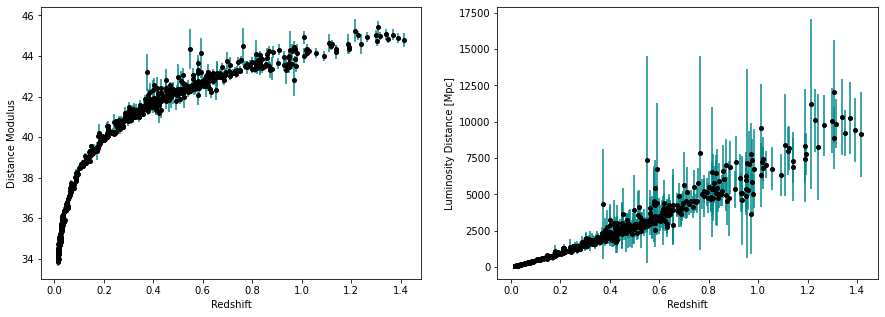

In [276]:
plt.subplots(1, 2, figsize=(15, 5))

# Plot distance modulus versus redshift (original data)
plt.subplot(1, 2, 1)
plt.xlabel("Redshift")
plt.ylabel("Distance Modulus")
plt.errorbar(zs, dist_mod, yerr=err_dist_mod, fmt='o', color='black', ecolor='darkcyan', markersize=4)

# Plot luminosity distance versus redshift
plt.subplot(1, 2, 2)
plt.xlabel("Redshift")
plt.ylabel("Luminosity Distance [Mpc]")
plt.errorbar(zs, dMpc, yerr=dMe, fmt='o', color='black', ecolor='darkcyan', markersize=4)
plt.show()

## <span style='color:deepskyblue'>Bayes' Theorem: Likelihood, Prior, Posterior (and Evidence...)</span>

The **conditional probability of A given that B is true** is denoted with $P(A|B)$ (read: *probability of A given B*). 
Did A happen? Then B has probability $P(B|A)$ of happening.

[**Bayes' Theorem**](https://en.wikipedia.org/wiki/Bayes%27_theorem) is simply a reflection of the symmetry of the concept of joint probability:

$$
P(A|B)P(B) = P(B|A)P(A)
$$

In physics, our goal is often to determine how likely the values of some parameters $\theta$ are, given how well they reproduce the data $D$. 
We write Bayes' theorem in the following equivalent form:

$$
P(\theta | D) = \frac{P(D|\theta)P(\theta)}{P(D)}
$$

The various terms conventionally take the names:

$$
\begin{aligned}
P(\theta | D) & && \text{Posterior}
\\
P(D | \theta)& && \text{Likelihood}
\\
P(\theta) & && \text{Prior}
\\
P(D) & && \text{Evidence}
\end{aligned}
$$

### <span style='color:deepskyblue'>Prior</span>

The *prior* quantifies our degree of prior belief in the model parameters. It can contain the results of previous experiments, or theoretical considerations (for instance, that certain parameters cannot be negative, etc.). 

We can have *strong priors* about something - the Sun still existing at night, see the comic below - or not.
When we do *not* have compelling prior knowledge about a parameter, we generally use a *non-informative* prior probability distribution, most often related to the [uniform distribution](https://en.wikipedia.org/wiki/Continuous_uniform_distribution)

$$
\begin{aligned}
    \text{Uniform} & && \theta \in \text{Uniform}[\theta_{\rm min}, \theta_{\rm max}]
    \\
    \text{Log Uniform} & && \log\theta \in \text{Uniform}[\log\theta_{\rm min}, \log\theta_{\rm max}]
\end{aligned}
$$

You may sometimes hear that "the prior doesn't matter". While this is not strictly true, it is however true that in many instances the *likelihood* depends more dramatically on the parameters and will have a dominating contribution to the posterior. You are more than welcome to try different priors for the model parameters and see if and how your results change.

### <span style='color:deepskyblue'>Likelihood</span>

The measure of how well our model reproduces the data is the **likelihood** $\mathcal L$. For normal (=Gaussian), uncorrelated data $\mu_i$ with errors $\sigma_i$ ($i = \{1,580\}$), the likelihood is related to the famous [**chi-squared**](https://en.wikipedia.org/wiki/Chi-square_distribution) via

$$
P(D | \theta) \equiv \mathcal L = \exp\left(-\frac{\chi^2}{2}\right)
\qquad
\qquad
\boxed{
\chi^2 \equiv \sum_{i=1}^{580} \frac{\left(\mu_i^{(\rm theor)} - \mu_i^{(\rm obs)}\right)^2}{\sigma_i^2}
}
$$

A *high likelihood* corresponds to a *low chi squared*.

In principle, we could attack the problem brute-force: create a grid of values for $h$, $\Omega_m$, $\Omega_\Lambda$, calculate the likelihood for each combination, and create a profile for the likelihood. 

In practical cases, however, this is not only sub-optimal but sometimes **impossible**. Think of complicated models with 20+ free parameters (this is not that unusual in physics, by the way). Even a very coarse grained grid of 100 values for each parameter would result in more than$10^{40}$ (!!!) different parameter combination to be tested. You can probably understand why this is undesirable.

### <span style='color:deepskyblue'>Evidence</span>

This is the tricky bit. The evidence, which is "*the probability of observing certain data*", is not something that is easy to evaluate or interpret. This looks like a serious limitation to finding the:


### <span style='color:deepskyblue'>Posterior</span>

What does the data tell us about the model parameters? The answer is the *posterior probability distribution*, often (but not necessarily) expressed as (average $\pm$ standard deviation)

$$
\theta_i = \bar\theta_i \pm \sigma_i
$$

In other words, the posterior tells us how likely it is for the model parameters to have certain values, *given that we observe the data* $D$.

*This is the final goal of our analysis!*

<br>

![title](http://1.bp.blogspot.com/-tTx4HDejSww/ULcTeK9_V_I/AAAAAAAAA8g/PCYOH-eXGbk/s1600/frequentists_vs_bayesians.png)
![title](https://i.redd.it/5r0hwixt0m931.jpg)

## <span style='color:deepskyblue'>Markov-Chain Monte Carlo</span>

Markov-Chain Monte Carlo techniques are a class of methods to sample a probability distribution $P(x)$ - in our case $P(\theta | D)$ - provided that we can calculate a density $\mathcal F(x)$ **that is proportional to it** - in our case $P(\theta)P(D|\theta)$ = likelihood $\times$ prior. Among these, a very popular one is the [**Metropolis-Hastings**](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) algorithm, which is what we will use.

Schematically, the algorithm works as follows:
* Start with an $n$-tuple of parameters $\theta_{\rm old} = \{\theta_1, \theta_2, \dots\}_{\rm old}$ (in our case $\theta = \{h,\Omega_m,\Omega_\Lambda\}$) and calculate the $\mathcal F_{\rm old}$
* Propose a new set of parameters $\theta_{\rm prop}$, calculate the new corresponding $\mathcal F_{\rm prop}$. How you propose the new parameters is not essential as long as the probability of going from one set of parameters to the next is the same as the inverse: $P(\theta_a \to \theta_b) = P(\theta_b \to \theta_a)$. For this, we normally take Gaussian displacements with some (relatively small) standard deviation.
* Compare the new and old likelihoods-priors:
    * If $\mathcal F_{\rm prop} > \mathcal F_{\rm old}$, accept the step: $\theta_{\rm new} = \theta_{\rm prop}$
    * Otherwise, accept with probability $P_{\rm accept} = \mathcal F_{\rm prop}/\mathcal F_{\rm old}$
* If accepted, $\theta_{\rm new} = \theta_{\rm prop}$ and record the step; otherwise, $\theta_{\rm new} = \theta_{\rm old}$ (no re-recording)
* Update $\theta_{\rm old} = \theta_{\rm new}$
* Repeat

The MC chain keeps going until the desired number of steps or, ideally, when a suitable convergence test, like for example the [Gelman-Rubin test](https://bookdown.org/rdpeng/advstatcomp/monitoring-convergence.html), is satisfied. 
Today we will just set a limit to the total number of steps, but please feel free to implement and test your favourite convergence test!

Looking at equation (4), you can convince yourself that
$$
\frac{\mathcal L_a}{\mathcal L_b} = \exp\left(\frac{\chi_b^2 - \chi_a^2}{2}\right)
$$

(This is useful because $\chi^2$ can be large, so we want to avoid the likelihoods evaluating to `0.` -- computers don't like dividing by zero, unfortunately)
 
* Start with an $n$-tuple of parameters $\theta_{\rm old} = \{\theta_1, \theta_2, \dots\}_{\rm old}$ (in our case $\theta = \{h,\Omega_m,\Omega_\Lambda\}$) and the corresponding chi squared $\chi_{\rm old}^2$ (to be clear, for us this implies calculating a series of 580 integrals and comparing each with the observed values)
* Propose new parameters $\theta_{\rm prop}$ and calculate the corresponding chi squared $\chi_{\rm prop}^2$
* Draw a random number $r \in [0,1]$
* Accept the step if 
$$
r < \exp\left(\frac{\chi_{\rm old}^2 - \chi_{\rm prop}^2}{2}\right) \frac{P(\theta)_{\rm prop}}{P(\theta)_{\rm old}}
$$
    * If accepted, update $\theta_{\rm old} = \theta_{\rm prop}$, and record; otherwise, $\theta_{\rm new} = \theta_{\rm old}$ (no re-recording)
* Repeat

In [277]:
# Function to calculate the theoretical distance modulus (copied from Lorenzo)
def the_dist_mod(z, h0, O_M, O_L):
    return 5. * (-1. + np.log10(dL(z, h0, O_M, O_L)))

In [278]:
print(zs.shape)

(580,)


In [279]:
# Function to change the parameters theta. After some experimentation, I found 
# that for omega_m and omega_l, a standard deviation of 0.001 for the gaussian distribution
# worked quite well, for h0, I chose a standard deviation of 0.3

def change_theta(theta_old):
  
  theta_new = np.zeros(shape=(3))

  r = [random.gauss(0, 0.3)]
  while theta_old[0] + r > 90 or theta_old[0] + r < 50:
    r = [random.gauss(0, 0.3)]
  theta_new[0] = theta_old[0] + r
 
  r = [random.gauss(0, 0.001)]
  while theta_old[1] + r > 1.5 or theta_old[1] + r < 0.0:
    r = [random.gauss(0, 0.001)]
  theta_new[1] = theta_old[1] + r

  r = [random.gauss(0, 0.001)]
  while theta_old[2] + r > 1.5 or theta_old[2] + r < -0.5:
    r = [random.gauss(0, 0.001)]
  theta_new[2] = theta_old[2] + r
  
  return theta_new


In [280]:
# Setting initial conditions
# h0, O_m, O_l
theta_old = np.array([70. , 0.3, 0.7])

sum = 0
for i in range(0, zs.shape[0]):
  term = ((the_dist_mod(zs[i], theta_old[0], theta_old[1], theta_old[2]) - dist_mod[i])**2/ err_dist_mod[i]**2)
  sum = sum + term
xi2_old = sum

print(xi2_old)

564.9843613730237


In [281]:
# Actual Algorithem 
# h0, O_m, O_L
epochs = 1000
e = 0
# Creating the data type for the Array
dtype = [('h0', (np.str, 18)), ('Omega_M', (np.str, 18)), ('Omega_L', (np.str, 18)), ('Xi2', (np.str, 18))]
Arr = np.array([], dtype=dtype)
while e < epochs:
  theta_new = change_theta(theta_old) #Changing a new theta
  sum = 0
  # Calculating xi2
  for i in range(0, zs.shape[0]):
    term = ((the_dist_mod(zs[i], theta_new[0], theta_new[1], theta_new[2]) - dist_mod[i])**2/ err_dist_mod[i]**2)
    sum = sum + term
  xi2 = sum

  # Accepting or rejecting the new parameters
  if random.random() < math.exp((xi2_old - xi2)/ 2):
    Arr = np.append(Arr, np.array((round(theta_new[0], 14), round(theta_new[1], 14), round(theta_new[2], 14), round(xi2, 14)), dtype=dtype))
    xi2_old = xi2
    theta_old = theta_new
    e = e +1
    if e % 100 == 0: print(e, theta_old, xi2_old)


100 [69.60771985  0.28542929  0.70997953] 563.8111184218304
200 [70.00174172  0.28218941  0.70426331] 562.8436377013494
300 [69.56007898  0.28257487  0.69114576] 563.6983966092788
400 [69.48002516  0.28393823  0.68957823] 564.3901720044651
500 [69.70259019  0.29693817  0.68455133] 564.0305624821546
600 [68.79230338  0.31619795  0.67506901] 575.2058613454085
700 [69.55077179  0.31163869  0.66354195] 567.1307206865206
800 [69.36575701  0.29770844  0.67275154] 565.4397662375849
900 [69.22350677  0.28908023  0.68108409] 567.3951801274828
1000 [69.55356297  0.3005686   0.66707161] 565.3191069923317


In [282]:
np.savetxt( 'MonteCarloOutput3' + '.txt', Arr, fmt='%s', delimiter=',', header='h0, Omega_M, Omega_L, xi2', comments='')

After completion of the programme, your MC chain will (*hopefully*) look something like this:

`#Omega_m  Omega_L  h   
 0.297     0.703    69.8
 0.285     0.715    70.1
 0.288     0.712    69.9
 ...
`

## <span style='color:deepskyblue'>Plotting: GetDist</span>

We will do the plots with [`GetDist`](https://getdist.readthedocs.io/en/latest/plot_gallery.html).

The plot gallery contains a lot of useful examples, you should be able to read them fairly easily and see which applies to your situation. Look for both (triangle) plots and for parameter estimation.

Note that many `GetDist` functions require arguments of type `MCSamples`; make sure you convert your lists accordingly.

Removed no burn in


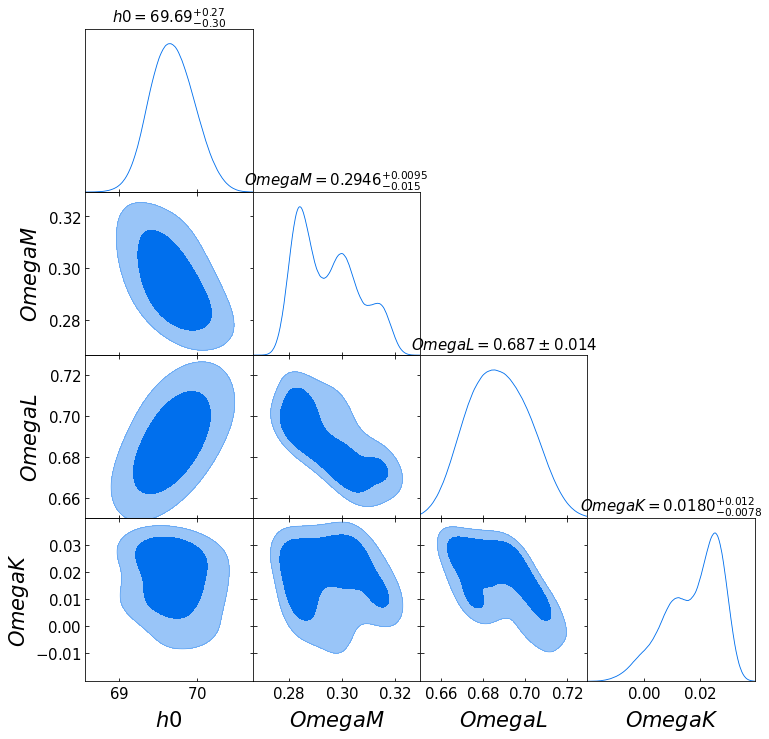

In [283]:
import getdist, IPython
from getdist import plots, MCSamples, loadMCSamples
#print('Version: ',getdist.__version__)
import numpy as np
import pylab
from random import random
from random import gauss


path = r"/content/MonteCarloOutput3.txt"
f = np.loadtxt(path, skiprows=1, delimiter=",")
H0, OM, OL, XI2 = f[:,0], f[:,1], f[:,2], f[:,3]
OK = 1 - OM - OL

# If you want to use LaTeX in the labels. Not mandatory, but it looks nice ;)
pylab.rc('text',usetex=False)

my_dim = 4

my_labels = ['h0', 'Omega M', 'Omega L', 'Omega K']
my_names = ["x%s" % i for i in range(my_dim)]
my_ranges = {'x0': (-0.5, 0.5)}
my_samples = np.array([H0, OM, OL, OK])
my_samples = np.transpose(np.reshape(my_samples,(my_dim,int(my_samples.size/my_dim))))
samples = MCSamples(samples=my_samples,names = my_names, labels = my_labels)

#Triangle corner plot
j = plots.getSubplotPlotter(subplot_size=3)
j.settings.axes_labelsize = 22
j.settings.axes_fontsize = 16
j.triangle_plot(samples, filled = True, title_limit=1)

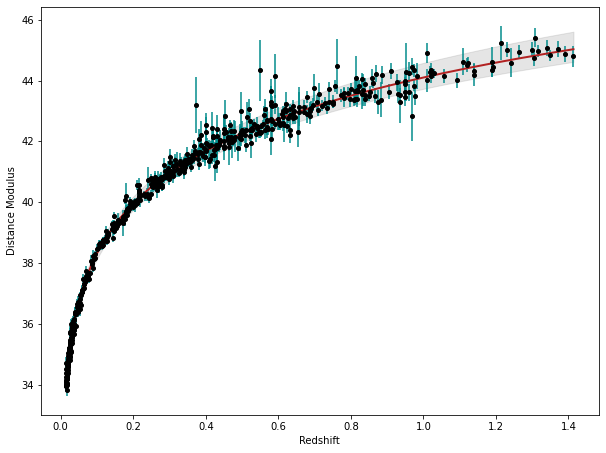

In [284]:
# example of theoretical curves
SPEED_OF_LIGHT = 299792.458 # in km/s

# Still need to add Omega_k!
def theor_luminosity_distance(z, h, OmegaM, OmegaL):
    return 10.**6 * SPEED_OF_LIGHT / h * (1.+z) * \
    integrate.quad(lambda x: 1. / np.sqrt(OmegaM * (1.+x)**3 + OmegaL), 0., z)[0]

def theor_distance_modulus(z, h, OmegaM, OmegaL):
    return 5. * (-1. + np.log10(theor_luminosity_distance(z, h, OmegaM, OmegaL)))
                 
zsort = sorted(zs)
d_best_fit, d_min, d_max = [], [], []

# YOUR RESULTS GO HERE!
for z in zsort:
    d_best_fit.append(theor_distance_modulus(z, 70., 0.3, 0.7))
    d_min.append(theor_distance_modulus(z, 75., 0.5, 0.5))
    d_max.append(theor_distance_modulus(z, 65., 0.1, 0.9))
    
plt.subplots(figsize=(10, 7.5))
plt.xlabel("Redshift")
plt.ylabel("Distance Modulus")

plt.errorbar(zs, dist_mod, yerr=err_dist_mod,\
             fmt='o', color='black', ecolor='darkcyan', markersize=4)
plt.plot(zsort, d_best_fit, color='firebrick',linewidth=2.)
plt.fill_between(zsort, d_min, d_max, color='grey', alpha=.2)
plt.show()